In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import torch
from sbi.utils import BoxUniform

from sbi.inference import simulate_for_sbi
from sbi.utils.user_input_checks import process_simulator, process_prior, check_sbi_inputs


In [2]:
v = 1
a = 1

# SBI

## prior

In [3]:
# low = torch.tensor([0.5, 0.5])
# high = torch.tensor([2, 2])

low = torch.tensor([0.95,0.95])
high = torch.tensor([1.05,1.05])

prior = BoxUniform(low=low, high=high)
prior, num_parameters, prior_returns_numpy = process_prior(prior)

## simulate single bound

In [4]:
def simulate_PA(params):
    v,a = params
    dt = 1e-4; dB = 1e-2
    DV = 0; t = 0
    while True:
        DV += v*dt + np.random.normal(0, dB)
        t += dt

        if DV >= a:
            return t


## sbi simulator

In [5]:
simulator = process_simulator(simulate_PA, prior, prior_returns_numpy)

In [6]:
check_sbi_inputs(simulator, prior)

In [7]:
N_sim = int(50e3)

proposal = prior
theta, x_o = simulate_for_sbi(simulator=simulator,\
                            proposal=proposal,
                            num_simulations=N_sim,
                            num_workers=32)

  0%|          | 0/50000 [00:00<?, ?it/s]

## train network

In [8]:
from sbi.inference import SNLE
trainer = SNLE()
x_o_2d = torch.atleast_2d(x_o)
estimator = trainer.append_simulations(theta, x_o_2d.T).train(training_batch_size=512)

/home/rka/code/ddm_codes/venv/lib/python3.10/site-packages/sbi/neural_nets/net_builders/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel = get_numel(


 Neural network successfully converged after 29 epochs.

## likelihood

In [9]:
bin_width = 0.1
bins = np.arange(0, 4, bin_width)
t_pts = bins[:-1] + bin_width/2
sim_results = Parallel(n_jobs=-1)(delayed(simulate_PA)([v,a]) for _ in range(int(50e3)))



In [10]:
og_params = torch.Tensor([v, a])
loglike = estimator.log_prob(torch.tensor(t_pts).unsqueeze(0).to(dtype=torch.float32), torch.tensor([[v, a]] * len(t_pts)) )
like = torch.exp(loglike)

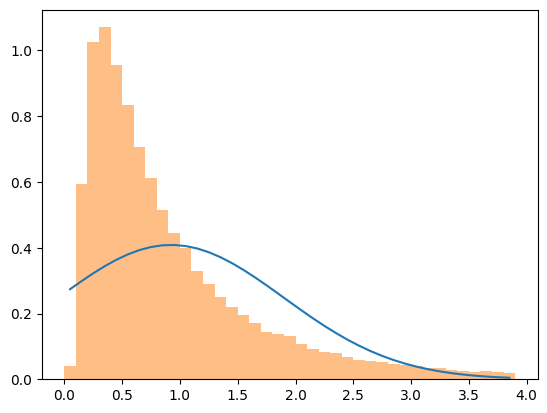

In [11]:
plt.plot(t_pts, like.squeeze().detach().numpy())
plt.hist(sim_results, bins=bins, density=True, alpha=0.5);

## losses?

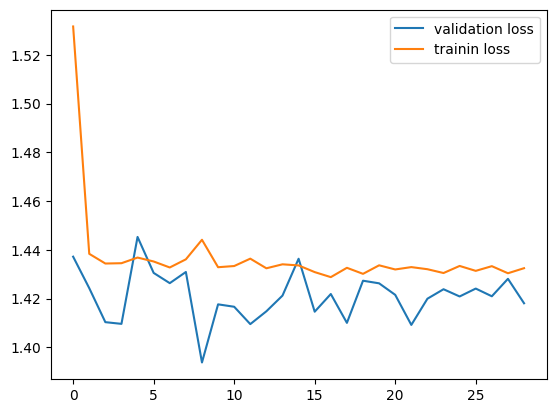

In [12]:
plt.plot(trainer.summary['validation_loss'], label='validation loss')
plt.plot(trainer.summary['training_loss'], label='trainin loss')
plt.legend()

## how are the priors?

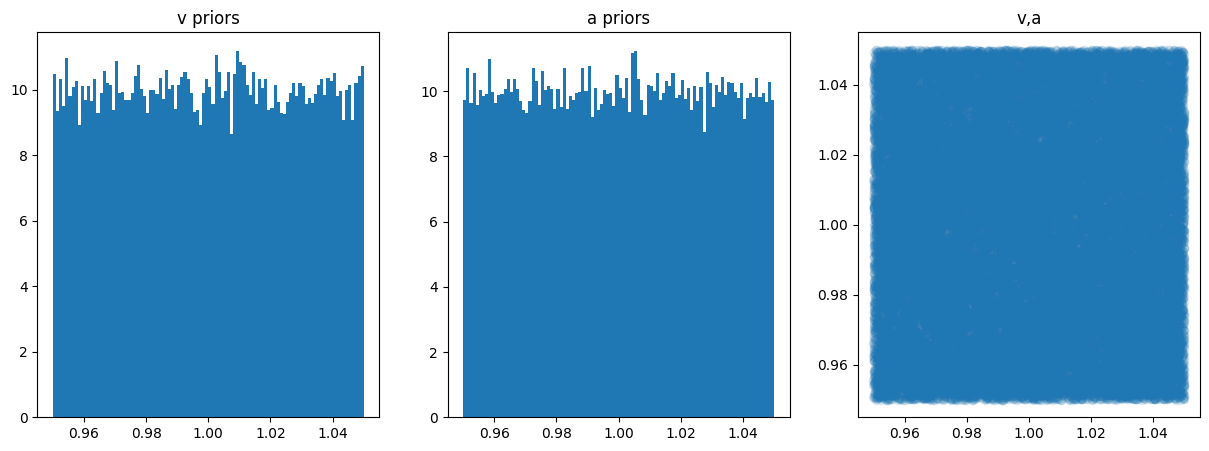

In [13]:
v_prior = theta[:,0].numpy()
a_prior = theta[:,1].numpy()

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title('v priors')
plt.hist(v_prior, bins=100, density=True)

plt.subplot(1,3,2)
plt.title('a priors')
plt.hist(a_prior, bins=100, density=True);

plt.subplot(1,3,3)
plt.title('v,a')
plt.scatter(v_prior, a_prior, alpha=0.1)

# check simulator?

  0%|          | 0/10000 [00:00<?, ?it/s]

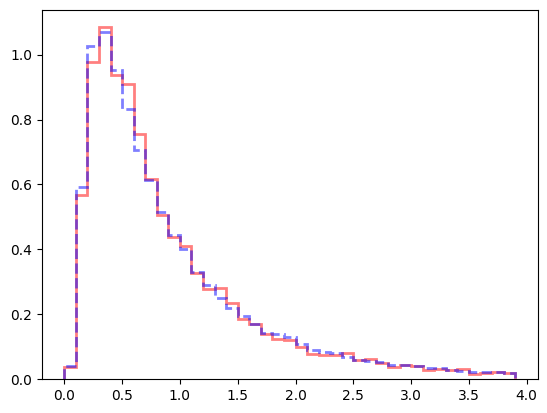

In [14]:
prior_1 = BoxUniform(low=torch.tensor([v,a]), high=torch.tensor([v,a]))
prior_1, num_parameters_1, prior_returns_numpy_1 = process_prior(prior_1)
check_sbi_inputs(simulator, prior_1)
proposal_1 = prior_1
theta_1, x_o_1 = simulate_for_sbi(simulator=simulator,\
                            proposal=proposal_1,
                            num_simulations=10000,
                            num_workers=32)

x_o_1_np = x_o_1.numpy()

plt.hist(x_o_1_np, bins=bins, density=True, alpha=0.5, histtype='step', lw=2, color='r');
plt.hist(sim_results, bins=bins, density=True, alpha=0.5, histtype='step', lw=2, color='b', ls='--');

In [15]:
trainer._neural_net

NFlowsFlow(
  (net): Flow(
    (_transform): CompositeTransform(
      (_transforms): ModuleList(
        (0): PointwiseAffineTransform()
        (1): MaskedAffineAutoregressiveTransform(
          (autoregressive_net): MADE(
            (initial_layer): MaskedLinear(in_features=1, out_features=50, bias=True)
            (context_layer): Linear(in_features=2, out_features=50, bias=True)
            (blocks): ModuleList(
              (0-1): 2 x MaskedFeedforwardBlock(
                (linear): MaskedLinear(in_features=50, out_features=50, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
            (final_layer): MaskedLinear(in_features=50, out_features=2, bias=True)
          )
        )
        (2): RandomPermutation()
        (3): MaskedAffineAutoregressiveTransform(
          (autoregressive_net): MADE(
            (initial_layer): MaskedLinear(in_features=1, out_features=50, bias=True)
            (context_layer): Linear(in_feature

## sample likelihood

In [33]:
np.random.uniform()

0.0854765088752647

(0.0, 0.5)

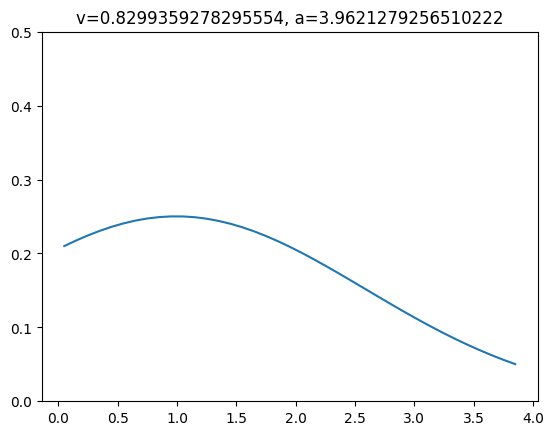

In [91]:
v_rand = 5*(np.random.uniform())
a_rand = 5*(np.random.uniform())
loglike_rand = estimator.log_prob(torch.tensor(t_pts).unsqueeze(0).to(dtype=torch.float32), torch.tensor([[v_rand, a_rand]] * len(t_pts)) )
like_1 = torch.exp(loglike_rand)

plt.plot(t_pts, like_1.squeeze().detach().numpy(), label='random')
plt.title(f'v={v_rand}, a={a_rand}')
plt.ylim(0, 0.5)